## Proyecto 3

# Emilio Frausto
# Juan Yael Vazques 

Gen 0: {'min': np.float64(2.6461605646199575), 'max': np.float64(6.5486065804604735e+19)}
Gen 100: {'min': np.float64(0.2487324088638927), 'max': np.float64(3.530778991916978e+28)}
Gen 200: {'min': np.float64(0.24597025173238973), 'max': np.float64(3.53077900256707e+28)}
Gen 300: {'min': np.float64(0.2360258751381819), 'max': np.float64(3.53077900256707e+28)}
Gen 400: {'min': np.float64(0.23555527504014845), 'max': np.float64(3.5307790020029313e+28)}

🧩 Mejor individuo encontrado:
 safe_neg_exp(safe_div(safe_exp(safe_cos(safe_sin(add(x, mul(1.8429890460617009, x))))), sub(-1.0585721864991284, add(t, -1.4214758375345569))))
u(0, 0.1) = 0.000032
u(0.5, 0.1) = 0.000000
u(1, 0.1) = 0.000050
Longitud del árbol: 15


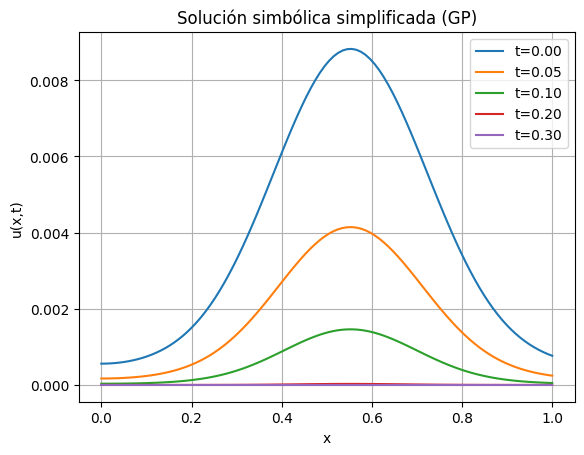

In [25]:
import operator, math, random
import numpy as np
import matplotlib.pyplot as plt
from deap import base, creator, gp, tools, algorithms


# 1. Definir el conjunto de funciones (nodos del árbol)
pset = gp.PrimitiveSet("MAIN", 2)  # dos entradas: x, t
pset.renameArguments(ARG0='x')
pset.renameArguments(ARG1='t')

# Operadores básicos
pset.addPrimitive(operator.add, 2)
pset.addPrimitive(operator.sub, 2)
pset.addPrimitive(operator.mul, 2)

# División segura
def safe_div(a, b):
    try:
        return a / b if abs(b) > 1e-6 else 1.0
    except:
        return 1.0
pset.addPrimitive(safe_div, 2)

# Funciones matemáticas seguras
def safe_sin(x): return math.sin(x)
def safe_cos(x): return math.cos(x)
def safe_exp(x):
    try: return math.exp(x) if x < 10 else math.exp(10)
    except: return 1.0
def safe_log(x):
    try: return math.log(abs(x)+1e-6)
    except: return 0.0
def safe_neg_exp(x):
    try:
        return math.exp(-abs(x)) if x > -20 else math.exp(20)
    except OverflowError:
        return 1.0

pset.addPrimitive(safe_neg_exp, 1)
pset.addPrimitive(safe_sin, 1)
pset.addPrimitive(safe_cos, 1)
pset.addPrimitive(safe_exp, 1)
pset.addPrimitive(safe_log, 1)

# Constantes aleatorias
pset.addEphemeralConstant("rand101", lambda: random.uniform(-2, 2))

# 2. Crear tipos DEAP

try:
    del creator.FitnessMin
    del creator.Individuo
except:
    pass

creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individuo", gp.PrimitiveTree, fitness=creator.FitnessMin)

toolbox = base.Toolbox()
toolbox.register("expr_init", gp.genHalfAndHalf, pset=pset, min_=2, max_=4)
toolbox.register("individuo", tools.initIterate, creator.Individuo, toolbox.expr_init)
toolbox.register("population", tools.initRepeat, list, toolbox.individuo)
toolbox.register("compile", gp.compile, pset=pset)

# 3. Evaluación física (residuo de la ecuación de calor)
xs = np.linspace(0, 1, 10)
ts = np.linspace(0, 0.3, 10) # que aprenda a que se disipa lentamente, no rapidamenete 
def evaluar(individuo):
    func = toolbox.compile(expr=individuo)
    h = 1e-3
    error_pde = 0.0
    n = 0

    for x in xs:
        for t in ts:
            try:
                u = func(x, t)
                du_dt = (func(x, t+h) - func(x, t-h)) / (2*h)
                d2u_dx2 = (func(x+h, t) - 2*u + func(x-h, t)) / (h**2)
                residuo = du_dt - d2u_dx2
                error_pde += residuo**2
                n += 1
            except (OverflowError, ValueError):
                return (1e6,)

    if n == 0: return (1e6,)

    mse_pde = error_pde / n

    # --- errores físicos principales ---
    mse_pde = error_pde / n
    u_init_error = np.mean([(func(x,0) - 0.2*math.sin(3*math.pi*x))**2 for x in xs])
    border_penalty = sum(abs(func(0,t)) + abs(func(1,t)) for t in ts)

    # --- amplitud: para que no se vuelva plano ---
    amp = np.mean([abs(func(x,0)) for x in xs])
    amp_penalty = 1e-4/(amp + 1e-6)   # favorece amplitud no-cero

    # --- complejidad, funciones no tan largas ---
    size_penalty = len(individuo) * 1e-3

    # --- estructura / forma ---
    expr_str = str(individuo)
    penalty_logx  = 1.0 if "safe_log(x)" in expr_str else 0.0
    penalty_no_exp = 0.5 if "safe_neg_exp" not in expr_str else 0.0

    # --- signo y decaimiento suave ---
    # media espacial en varios tiempos => debe ser positiva, monótona no-creciente y no desaparecer "demasiado" rápido
    times_chk = [0.0, 0.05, 0.1, 0.2, 0.3]
    A = []
    for tt in times_chk:
        A.append(np.mean([func(x, tt) for x in xs]))
    A = np.array(A)

    sign_penalty = 0.1 if A.mean() < 0 else 0.0
    mono_penalty = 0.0
    for i in range(len(A)-1):
        if A[i+1] > A[i] + 1e-6:   # no debe aumentar con t
            mono_penalty += 0.05

    # evita que se “aplane” de golpe: exige que no caiga más rápido que exp(-c_min t)
    c_min = 1.5                        # decaimiento mínimo (suave). Ajustable.
    too_fast = (abs(A[-1]) < abs(A[0]) * math.exp(-c_min * times_chk[-1]))
    speed_penalty = 0.1 if too_fast else 0.0
    
    # Penalizar funciones que no cambian con el tiempo
    t0, t1 = 0.0, 0.2
    u_t0 = np.array([func(x, t0) for x in xs])
    u_t1 = np.array([func(x, t1) for x in xs])
    temporal_diff = np.mean(np.abs(u_t1 - u_t0))
    time_penalty = 0.5 if temporal_diff < 1e-3 else 0

    # Penalizar si u(x,t) no decae con el tiempo
    decay_penalty = 0
    for x in xs:
        u_vals = [func(x, t) for t in ts]
        if any(u_vals[i+1] > u_vals[i] + 1e-3 for i in range(len(u_vals)-1)):
            decay_penalty += 0.2


    # --- mezcla de pesos (ajústalos si quieres) ---
    fitness = (
        1.5 * mse_pde +
        5.0 * u_init_error +
        5.0 * border_penalty +
        0.9 * amp_penalty +
        1.0 * size_penalty +
        1.0 * penalty_logx +
        0.5 * penalty_no_exp +
        1.0 * sign_penalty +
        1.0 * mono_penalty +
        0.9 * speed_penalty +
        1.7 * time_penalty +
        0.8 * decay_penalty
    )


    return (fitness,)

toolbox.register("evaluate", evaluar)

# 4. Operadores genéticos

toolbox.register("mate", gp.cxOnePoint)
toolbox.register("expr_mut", gp.genFull, min_=1, max_=3)
toolbox.register("mutate", gp.mutUniform, expr=toolbox.expr_mut, pset=pset)
toolbox.register("select", tools.selTournament, tournsize=3)

toolbox.decorate("mate", gp.staticLimit(key=operator.attrgetter("height"), max_value=14))
toolbox.decorate("mutate", gp.staticLimit(key=operator.attrgetter("height"), max_value=14))


# 5. Evolución con elitismo

poblacion = toolbox.population(n=300)
hof = tools.HallOfFame(5)  # guardamos los 5 mejores individuos

stats = tools.Statistics(lambda ind: ind.fitness.values)
#stats.register("avg", np.mean)
#stats.register("std", np.std)
stats.register("min", np.min)
stats.register("max", np.max)

generaciones = 500
p_cruza = 0.4
p_muta = 0.6

for gen in range(generaciones):
    # --- Evaluar población inicial ---
    invalid_ind = [ind for ind in poblacion if not ind.fitness.valid]
    fitnesses = map(toolbox.evaluate, invalid_ind)
    for ind, fit in zip(invalid_ind, fitnesses):
        ind.fitness.values = fit

    # --- Guardar los mejores (elitismo) ---
    hof.update(poblacion)
    elites = tools.selBest(poblacion, k=15)
    offspring = tools.selTournament(poblacion, len(poblacion) - len(elites), tournsize=3)

    # --- Reproducción (cruce + mutación) ---
    offspring = algorithms.varAnd(offspring, toolbox, cxpb=p_cruza, mutpb=p_muta)

    # --- Evaluar descendencia ---
    invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
    fitnesses = map(toolbox.evaluate, invalid_ind)
    for ind, fit in zip(invalid_ind, fitnesses):
        ind.fitness.values = fit

    # --- Nueva población = élites + descendencia ---
    poblacion[:] = elites + offspring

    record = stats.compile(poblacion)
    if gen % 100 == 0:
        print(f"Gen {gen}: {record}")



# 6. Resultados

best = hof[0]
print("\n🧩 Mejor individuo encontrado:\n", best)
func_best = toolbox.compile(expr=best)
print(f"u(0, 0.1) = {func_best(0, 0.1):.6f}")
print(f"u(0.5, 0.1) = {func_best(0.05, 0.5):.6f}")
print(f"u(1, 0.1) = {func_best(1, 0.1):.6f}")
print("Longitud del árbol:", len(best))


# 7. Visualización

xs_plot = np.linspace(0,1,100)
for t_fixed in [0, 0.05, 0.1, 0.2, 0.3]:
    u_vals = [func_best(x, t_fixed) for x in xs_plot]
    plt.plot(xs_plot, u_vals, label=f"t={t_fixed:.2f}")

plt.title("Solución simbólica simplificada (GP)")
plt.xlabel("x")
plt.ylabel("u(x,t)")
plt.legend()
plt.grid(True)
plt.show()



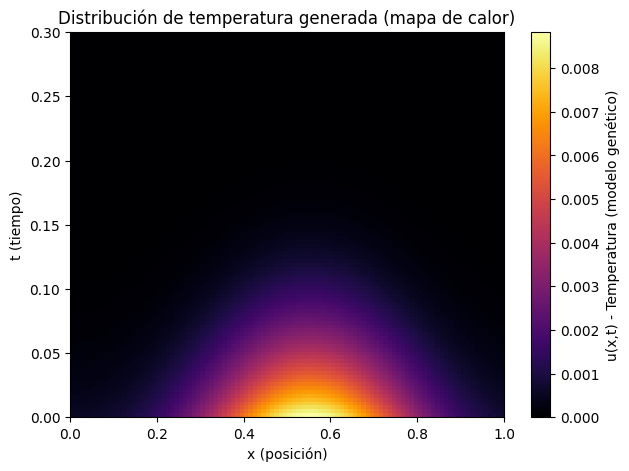

In [26]:
# --- 2️⃣ Mapa de calor con la función generada ---
xs_plot = np.linspace(0, 1, 100)
ts_plot = np.linspace(0, 0.3, 100)

# Matrices X, T y valores de U
X, T = np.meshgrid(xs_plot, ts_plot)
U = np.zeros_like(X)

for i, t in enumerate(ts_plot):
    for j, x in enumerate(xs_plot):
        try:
            U[i, j] = func_best(x, t)
        except:
            U[i, j] = np.nan  # por si algún valor se desborda

# --- Visualización ---
plt.figure(figsize=(7, 5))
plt.imshow(U, extent=[0, 1, 0, 0.3], origin='lower', aspect='auto', cmap='inferno')
plt.colorbar(label='u(x,t) - Temperatura (modelo genético)')
plt.title('Distribución de temperatura generada (mapa de calor)')
plt.xlabel('x (posición)')
plt.ylabel('t (tiempo)')
plt.show()